# Imports

In [18]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Dataset

Sample 1: <class 'PIL.JpegImagePlugin.JpegImageFile'>, size = (512, 512)


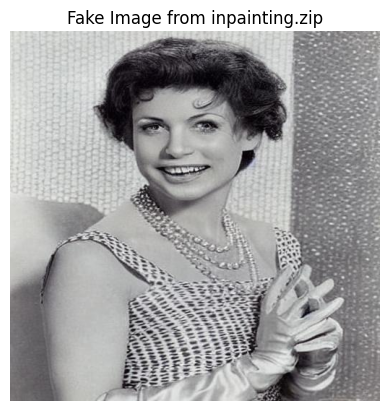

Sample 2: <class 'PIL.JpegImagePlugin.JpegImageFile'>, size = (512, 512)


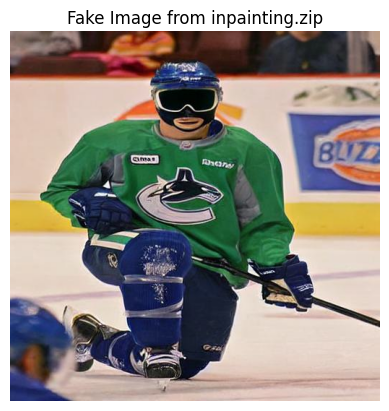

Sample 3: <class 'PIL.JpegImagePlugin.JpegImageFile'>, size = (512, 512)


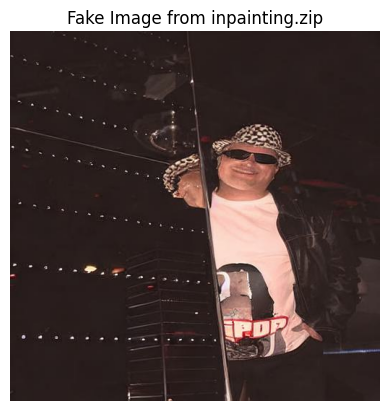

In [19]:
from datasets import load_dataset
import matplotlib.pyplot as plt

# Try streaming just 3 fake images
ds = load_dataset("OpenRL/DeepFakeFace", data_files="inpainting.zip", split="train", streaming=True)

for i, example in enumerate(ds):
    image = example['image']
    print(f"Sample {i+1}: {type(image)}, size = {image.size}")
    
    # Show image
    plt.imshow(image)
    plt.title("Fake Image from inpainting.zip")
    plt.axis('off')
    plt.show()

    if i == 2:
        break




def load_real_vs_fake_dataset(image_size=(224, 224), test_size=0.2, max_per_class=100):
    from datasets import load_dataset
    from PIL import Image
    import numpy as np
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.utils import to_categorical


    def load_zip(file_name, label, max_count):
        ds = load_dataset("OpenRL/DeepFakeFace", data_files=file_name, split="train", streaming=True)
        images, labels = [], []
        for i, example in enumerate(ds):
            if i >= max_count:
                break
            img = example['image'].resize(image_size, Image.BILINEAR)
            img_array = np.array(img).astype("float32") / 255.0

            # Ensure RGB shape
            if img_array.ndim == 2:
                img_array = np.stack([img_array] * 3, axis=-1)
            elif img_array.shape[2] == 1:
                img_array = np.concatenate([img_array] * 3, axis=-1)

            # Force final shape (224, 224, 3)
            img_array = img_array[:image_size[0], :image_size[1], :3]
            img_array = np.pad(
                img_array,
                ((0, max(0, image_size[0] - img_array.shape[0])),
                 (0, max(0, image_size[1] - img_array.shape[1])),
                 (0, 0)),
                mode='constant'
            )
            
            images.append(img_array)
            labels.append(label)
        return images, labels

    # Load small sample from both
    real_imgs, real_labels = load_zip("wiki.zip", label=0, max_count=max_per_class)
    fake_imgs, fake_labels = load_zip("inpainting.zip", label=1, max_count=max_per_class)

    # Combine
    all_images = np.stack(real_imgs + fake_imgs)
    all_labels = np.array(real_labels + fake_labels)

    # Train/test split
    x_train, x_test, y_train, y_test = train_test_split(
        all_images, all_labels, test_size=test_size, stratify=all_labels, random_state=42
    )

    # One-hot encode
    num_classes = 2
    y_train = to_categorical(y_train, num_classes)
    y_test = to_categorical(y_test, num_classes)

    return (x_train, y_train), (x_test, y_test), num_classes



In [20]:
# Load your data
(x_train, y_train), (x_test, y_test), num_classes = load_real_vs_fake_dataset(
    max_per_class=20
)

print(f"x_train shape: {x_train.shape}")
print(f"{x_train.shape[0]} training samples")
print(f"{x_test.shape[0]} test samples")

# Define your model as before
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(650, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(304, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(161, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(80, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)



x_train shape: (32, 224, 224, 3)
32 training samples
8 test samples
Epoch 1/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5312 - loss: 0.6891 - val_accuracy: 0.5000 - val_loss: 6.0899
Epoch 2/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.6562 - loss: 4.9475 - val_accuracy: 0.5000 - val_loss: 16.8918
Epoch 3/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5000 - loss: 18.9752 - val_accuracy: 0.5000 - val_loss: 2.1010
Epoch 4/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.5312 - loss: 4.5635 - val_accuracy: 0.5000 - val_loss: 1.6480
Epoch 5/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4375 - loss: 4.3133 - val_accuracy: 0.5000 - val_loss: 1.7394
Epoch 6/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4375 - loss: 3.2486 - val_accuracy: 0.5000 - val_loss: 1.8060
Epoch 7/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.4062 - loss: 2.6773 - val_accuracy: 0.5000 - val_loss: 1.0458
Epoch 8/10
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3750 - l

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.5000 - loss: 0.8412
Test loss: 0.8412
Test accuracy: 0.5000


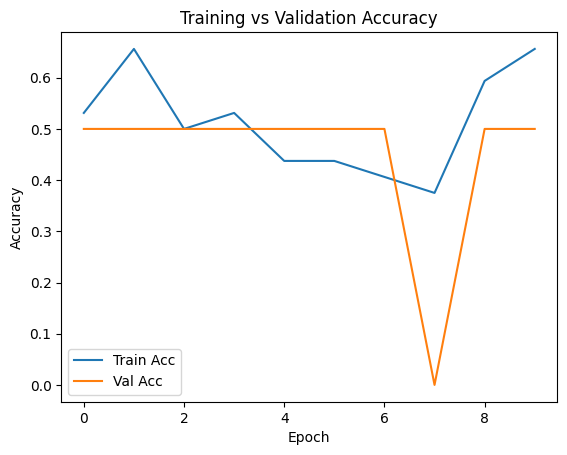

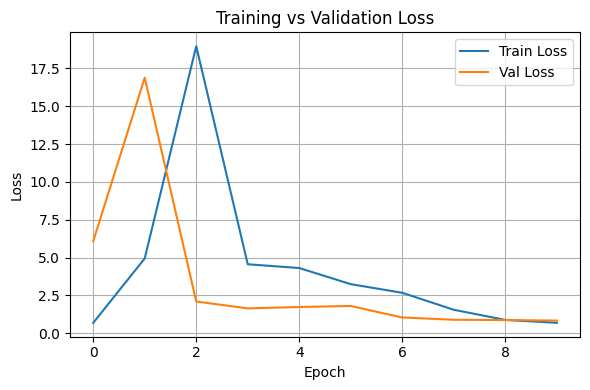

In [21]:
import matplotlib.pyplot as plt

# Evaluate
loss, acc = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {loss:.4f}')
print(f'Test accuracy: {acc:.4f}')



#Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()


# Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()